# **Machine Learning Exercise 4**
----------------------------------------------------------------------
The following notebook includes our code for the following tasks in Exercise 4:

1. Flower classification using VGG19 (Transfer learning)


---------------------------------------------------------------------------

We evaluated our implementations using the following evaluation metrics:

**Evaluation Metrics**:
1. Accuracy
2. Cross Entropy Loss

-------------------------------------------------------------------------
**Datasets**:
In our assignment, we used one dataset of flowers:

1. **102 Category Flower Dataset**:
This dataset consists 102 flower categories from the United Kingdom. Each class consists of between 40 and 258 images. The dataset is visualized using isomap with shape and colour features.


We stored our dataset in a google drive folder and uploaded it to the notebook using the download link




# Installations and Imports

In [1]:
#---------------------Installations---------------------#

!pip install kaggle scikit-learn pandas matplotlib
!pip install gdown


#---------------------Imports---------------------#
import tarfile
import os
import gdown
import scipy.io
import torch
from pathlib import Path

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import gc


import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



# Constants

In [2]:
#---------------------Constants---------------------#
TRAIN_SIZE = 0.5
VALIDATION_SIZE = 0.25
TEST_SIZE = 0.25
RANDOM_STATE = 42
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NORMALIZATION_RANGE = (0, 1)
EPOCHS = 20
LEARNING_RATE_VGG19 = 0.001
N_CLASSES = 102
DEGREES = 15
NUM_SPLITS = 2

data = {
    "imagelabels.mat": "https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4",
    "102flowers.tgz": "https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26"
}


# Download and Load Datasets

In [3]:
#dowloading the files into a directory called flower_data

os.makedirs("flower_data", exist_ok=True)


#downloading the mat files
for to_download in data:
  gdown.download(data[to_download], f"flower_data/{to_download}", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4
From (redirected): https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4&confirm=t&uuid=fe181f25-178d-4fac-8e2b-4b74f89c7912
To: /content/flower_data/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 1.60MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26
From (redirected): https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26&confirm=t&uuid=2927449c-987d-4ff6-bb4e-92c0648699e3
To: /content/flower_data/102flowers.tgz
100%|██████████| 345M/345M [00:07<00:00, 45.1MB/s]


In [4]:
extraction_folder = "flower_data"

with tarfile.open("/content/flower_data/102flowers.tgz", "r:gz") as tar:
    tar.extractall(extraction_folder)

print(f"Extracted files to: {extraction_folder}")

Extracted files to: flower_data


In [5]:
image_dir = Path("/content/flower_data/jpg")

all_images = sorted(image_dir.glob("*.jpg"))
all_images = [str(img) for img in all_images]
print(f"Total images found: {len(all_images)}")
print(f"Sample image paths: {all_images[:5]}")


Total images found: 8189
Sample image paths: ['/content/flower_data/jpg/image_00001.jpg', '/content/flower_data/jpg/image_00002.jpg', '/content/flower_data/jpg/image_00003.jpg', '/content/flower_data/jpg/image_00004.jpg', '/content/flower_data/jpg/image_00005.jpg']


In [6]:
labels_data = scipy.io.loadmat("/content/flower_data/imagelabels.mat")
labels = labels_data['labels'][0]
print(f"Number of labels: {len(labels)}")
print(f"Sample labels: {labels[:10]}")


Number of labels: 8189
Sample labels: [77 77 77 77 77 77 77 77 77 77]


In [7]:
image_label_pairs = [(str(image_path), label) for image_path, label in zip(all_images, labels)]

print(f"Total image-label pairs: {len(image_label_pairs)}")
print(f"Sample pairs: {image_label_pairs[:5]}")


Total image-label pairs: 8189
Sample pairs: [('/content/flower_data/jpg/image_00001.jpg', 77), ('/content/flower_data/jpg/image_00002.jpg', 77), ('/content/flower_data/jpg/image_00003.jpg', 77), ('/content/flower_data/jpg/image_00004.jpg', 77), ('/content/flower_data/jpg/image_00005.jpg', 77)]


##Train Test Split and Plotting Function##

In [8]:
#to use to clean memory
gc.collect()

0

In [9]:
splits = []

for i in range(NUM_SPLITS):
    train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
        all_images, labels, test_size=0.5, random_state=RANDOM_STATE, stratify=labels
    )

    val_imgs, test_imgs, val_labels, test_labels = train_test_split(
        temp_imgs, temp_labels, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_labels
    )

    train_labels = list(map(str, train_labels))
    val_labels = list(map(str, val_labels))
    test_labels = list(map(str, test_labels))

    splits.append((train_imgs, train_labels, val_imgs, val_labels, test_imgs, test_labels))


In [10]:
#------------------plotting the accuracy and loss------------------#
def plot_performance(history, test_acc, test_loss, model_name="VGG19"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"{model_name} Train Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"{model_name} Validation Accuracy")
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f"{model_name} Test Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"{model_name} Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"{model_name} Train Loss")
    plt.plot(history.history['val_loss'], label=f"{model_name} Validation Loss")
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f"{model_name} Test Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy Loss")
    plt.legend()
    plt.title(f"{model_name} Cross-Entropy Loss Over Epochs")

    plt.show()

##Building the VGG19 Model##

In [11]:
def build_vgg19_model():
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation="sigmoid")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation="sigmoid")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    out = Dense(N_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=out)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [14]:
test_accuracies_vgg19 = []
test_losses_vgg19 = []

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)


 Training on Dataset Split 1...

Found 4094 validated image filenames belonging to 102 classes.
Found 2047 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 72s 505ms/step - accuracy: 0.0490 - loss: 4.7241 - val_accuracy: 0.0699 - val_loss: 4.4155
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - accuracy: 0.3194 - loss: 3.0256 - val_accuracy: 0.4304 - val_loss: 3.5483
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - accuracy: 0.5904 - loss: 1.9055 - val_accuracy: 0.7005 - val_loss: 2.0089
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - accuracy: 0.7724 - loss: 1.2501 - val_accuracy: 0.7577 - val_loss: 1.3836
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 461ms/step - accuracy: 0.8731 - loss: 0.8215 - val_accuracy: 0.8251 - val_loss: 0.9221
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - accuracy: 0.9429 - loss: 0.5098 - val_accuracy: 0.8676 - val_loss: 0.7155
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 464ms/step - accuracy: 0.9645 - loss: 0.3492 - val_accuracy: 0.8657 - val_loss: 0.6432
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 508ms/step - accuracy: 0.9789 - loss: 0

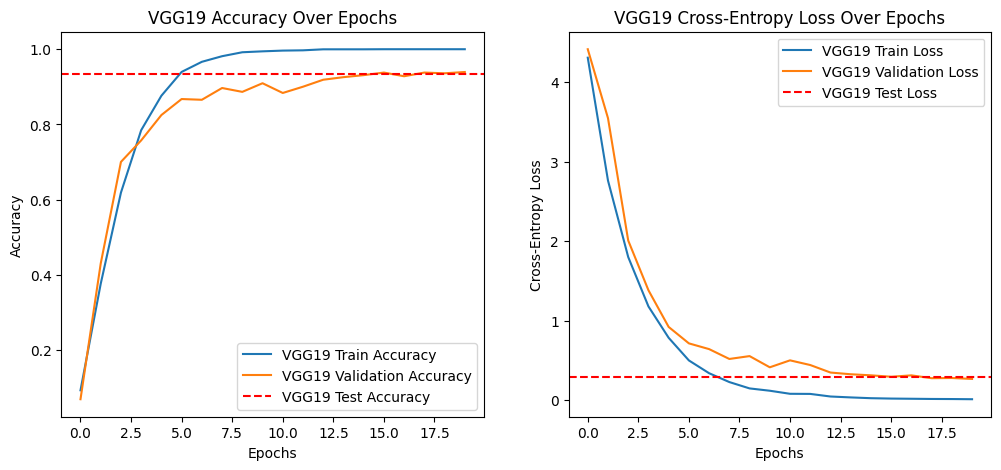


 Training on Dataset Split 2...

Found 4094 validated image filenames belonging to 102 classes.
Found 2047 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.0661 - loss: 4.6066 - val_accuracy: 0.0371 - val_loss: 4.3318
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - accuracy: 0.3658 - loss: 2.7706 - val_accuracy: 0.4621 - val_loss: 3.4264
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.5988 - loss: 1.8646 - val_accuracy: 0.6683 - val_loss: 2.0890
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.7556 - loss: 1.2643 - val_accuracy: 0.7728 - val_loss: 1.2587
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - accuracy: 0.8637 - loss: 0.8389 - val_accuracy: 0.8212 - val_loss: 0.9076
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - accuracy: 0.9318 - loss: 0.5621 - val_accuracy: 0.8559 - val_loss: 0.7068
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - accuracy: 0.9659 - loss: 0.3697 - val_accuracy: 0.8461 - val_loss: 0.6823
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.9797 - loss: 0.2459 - val

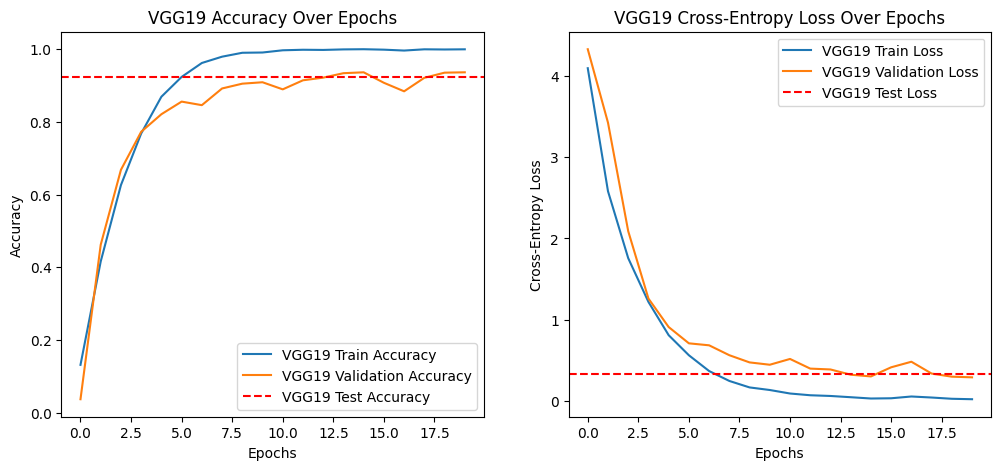

In [15]:
#------------------------------------training and testing VGG19 model---------------------------------------#
for split_idx, (train_imgs, train_labels, val_imgs, val_labels, test_imgs, test_labels) in enumerate(splits):
    print(f"\n Training on Dataset Split {split_idx + 1}...\n")

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_imgs, 'class': train_labels}),
        x_col="filename",
        y_col="class",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    val_generator = val_test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_imgs, 'class': val_labels}),
        x_col="filename",
        y_col="class",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': test_imgs, 'class': test_labels}),
        x_col="filename",
        y_col="class",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    model = build_vgg19_model()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    test_accuracies_vgg19.append(test_acc)
    test_losses_vgg19.append(test_loss)
    print(f"\n VGG19 Test Accuracy for Split {split_idx + 1}: {test_acc:.4f}\n")

    plot_performance(history, test_acc, test_loss, model_name="VGG19")